<a href="https://colab.research.google.com/github/n-bzy/iannwtf/blob/main/homework06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 06: Optimization of network

Transforming from standard CCN to ResNet CNN <br>
    

> Effect <br>
> Before: training loss from 1.96 to 1.09, test loss from 1.85 to 1.10 <br>
> After: training loss from 1.75 to 0.55, test loss from 1.7 to 0.7

---
    
1. Simplify the model<br>
    how: Removing the last layer (from 4 layers {64, 128, 256, 512 filters respectively} to 3 layers {64, 128, 256 filters respectively}
    <br>why: Model was overfitting after appr. 5 epochs (test loss after epoch 5: 0.7, test loss after epoch 14: 0.99)
    <br>result: model is not overfitting anymore
2. Use BatchNormalization<br>
    how: `tf.keras.BatchNormalization()` as additional layers
    <br>why: Should help with learnability
    <br>result: Does not work in our case, test_loss is still increasing
3. Use Dropout<br>
    how: `tf.keras.Dropout()` as additional layers.
    <br>why: Helps with overfitting
    <br>result: Works well, no more overfitting, test_loss of 0.59
4. Kernel regularizer<br>
    how: `kernel_regularizer=tf.keras.reguralizers.L2(0.001)`
    <br>why: Use regularization to prevent overfitting.
    <br>result: Improves the overfitting but not as good as dropout
5. Reduce batch size<br>
    how:`data.batch(256)` -> `data.batch(64)`
    <br>why: Adding stochasticity
    <br>result: Loss is decreasing faster, but test loss at the end stays the same.

# Homework 05 (without optimization)

In [41]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

train_ds, val_ds = tfds.load('cifar10', split=['train', 'test'], as_supervised=True)

def preprocessing(data):
    """Preparing data sets for use in CNN"""
    data = data.map(lambda x,t : (tf.cast(x, tf.float32), t))
    data = data.map(lambda x,t : ((x/255.), t))
    data = data.map(lambda x,t : (x, tf.one_hot(t, depth=10)))

    data = data.cache()
    data = data.shuffle(1000)
    data = data.batch(64)
    data = data.prefetch(tf.data.AUTOTUNE)

    return data

# Test preprocessing and check for value and target shapes 
# (important for initializing of model with input values)
train_test = preprocessing(train_ds)

for x, t in train_test.take(1):
    print(x.shape, t.shape)

(64, 32, 32, 3) (64, 10)


# Classic CNN

In [ ]:
class ClassicCNN(tf.keras.Model):
    """Initialize the CNN"""
    def __init__(self):
        super().__init__()
        self.layer1_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, 
                                        padding='same', activation='relu')
        self.layer1_2 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, 
                                        padding='same', activation='relu')
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)
        self.layer2_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, 
                                        padding='same', activation='relu')
        self.layer2_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, 
                                        padding='same', activation='relu')
        self.pool2 = tf.keras.layers.GlobalAvgPool2D()
        self.out = tf.keras.layers.Dense(10, activation='softmax')

        self.optimizer = tf.keras.optimizers.Adam()
        self.loss_function = tf.keras.losses.CategoricalCrossentropy()
        self.metrics_list = [
            tf.keras.metrics.Mean(name='loss'),
            tf.keras.metrics.CategoricalAccuracy(name='accuracy')
            ]
    
    def call(self, x, training=False):
        """Pass the input trough the CNN"""
        x = self.layer1_1(x)
        x = self.layer1_2(x)
        x = self.pool1(x)
        x = self.layer2_1(x)
        x = self.layer2_2(x)
        x = self.pool2(x)
        y = self.out(x)
        return y

    def reset_metrics(self):
        for metric in self.metrics_list:
            metric.reset_states()

    @tf.function
    def train(self, input):
        """Training step for CNN"""
        x,t = input

        with tf.GradientTape() as tape:
            output = self(x, training=True)
            loss = self.loss_function(t, output)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.metrics_list[0].update_state(values=loss)
        self.metrics_list[1].update_state(t, output)
        
        return {m.name:m.result() for m in self.metrics_list}
    
    @tf.function
    def test(self, input):
        """Testing step for CNN"""
        x,t = input
        output = self(x, training=False)
        loss = self.loss_function(t, output)

        self.metrics_list[0].update_state(values=loss)
        self.metrics_list[1].update_state(t, output)
        
        return {m.name:m.result() for m in self.metrics_list}

# ResNet CNN with bottleneck

In [42]:
class ResCNNBlock(tf.keras.layers.Layer):
    """Combine several conv2D-layers with use of bottleneck to a block"""
    def __init__(self, n_filters, b_filters, layers):
        """Initialize a first layer, bottleneck and Conv2D layers"""
        super().__init__()
        # First layer to get the input size match the output size
        self.deeper_layer = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=3, padding='same', activation='relu')
        # Use Bottleneck_in to reduce the depth of convolutional layers (b_filters << n_filters)
        self.bottleneck_in = tf.keras.layers.Conv2D(filters=b_filters, kernel_size=1, padding='same')
        self.layers = [tf.keras.layers.Conv2D(filters=b_filters, kernel_size=3, 
                        padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001)) for _ in range(layers)]
        # Use bottleneck_out to increase the depth back to the original size
        self.bottleneck_out = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=1, padding='same')

    def call(self, x):
        """Add the input to the output of the block for ResNet"""
        z = self.deeper_layer(x)
        c = self.bottleneck_in(z)
        for layer in self.layers:
            c = layer(c)
        c = self.bottleneck_out(c)
        # Add the (addapted) input to the output for Residual Learning
        x = z+c
        return x

class CNN(tf.keras.Model):
    """Combine several CNN blocks with pooling to a Convolutional Neuronal Network"""
    def __init__(self):
        """Initialize CNN blocks, pooling, optimizer, loss function and metrics"""
        super().__init__()

        self.block1 = ResCNNBlock(64, 16, 3)
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)
        # After pooling image size 16x16

        self.norm1 = tf.keras.layers.Dropout(0.5)
        self.block2 = ResCNNBlock(128, 32, 4)
        self.pool2 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)
        # After pooling image size 8x8

        self.norm2 = tf.keras.layers.Dropout(0.5)
        self.block3 = ResCNNBlock(256, 64, 20)
        self.pool3 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)
        # After pooling image size 4x4

        self.norm3 = tf.keras.layers.Dropout(0.5)
        self.block4 = ResCNNBlock(512, 128, 3)
        self.pool4 = tf.keras.layers.GlobalAvgPool2D()
        # After global pooling img size 1x1 for dense layer

        self.out = tf.keras.layers.Dense(10, activation='softmax')

        self.optimizer = tf.keras.optimizers.Adam()
        self.loss_function = tf.keras.losses.CategoricalCrossentropy()
        self.metrics_list = [
            tf.keras.metrics.Mean(name='loss'),
            tf.keras.metrics.CategoricalAccuracy(name='accuracy')
            ]
    
    def call(self, x, training=False):
        """Pass the input trough the CNN"""
        x = self.block1(x)
        x = self.pool1(x)

        x = self.norm1(x, training=training)
        x = self.block2(x)
        x = self.pool2(x)
        
        x = self.norm2(x, training=training)
        x = self.block3(x)
        x = self.pool3(x) 

        x = self.norm3(x, training=training)
        x = self.block4(x)
        x = self.pool4(x)

        y = self.out(x)
        return y

    def reset_metrics(self):
        """Function to reset every metric. Necessary for train_loop"""
        for metric in self.metrics_list:
            metric.reset_states()

    @tf.function
    def train(self, input):
        """Training step for CNN"""
        x,t = input

        with tf.GradientTape() as tape:
            output = self(x, training=True)
            loss = self.loss_function(t, output) + tf.reduce_sum(self.losses)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.metrics_list[0].update_state(values=loss)
        self.metrics_list[1].update_state(t, output)
        
        return {m.name:m.result() for m in self.metrics_list}
    
    @tf.function
    def test(self, input):
        """Testing step for CNN"""
        x,t = input
        output = self(x, training=False)
        loss = self.loss_function(t, output) + tf.reduce_sum(self.losses)

        self.metrics_list[0].update_state(values=loss)
        self.metrics_list[1].update_state(t, output)
        
        return {m.name:m.result() for m in self.metrics_list}

In [43]:
import tqdm

def training_loop(model, train_ds, val_ds, epochs):
    """Train and test the CNN for given epochs on given data"""

    train = preprocessing(train_ds)
    val = preprocessing(val_ds)

    # Save loss and accuracy as dictionaries in a list for visualization
    lists = []

    for n in range(epochs):
        print(f"Epoch {n}:")

        for data in tqdm.tqdm(train, position=0, leave=True):
            metrics = model.train(data)

        # Add metrics to list
        lists.append(metrics)
        print([f"{key}: {value.numpy()}" for (key,value) in metrics.items()])
        model.reset_metrics()

        for data in tqdm.tqdm(val, position=0, leave=True):
            metrics = model.test(data)

        # Add metrics to list
        lists.append(metrics)
        print([f"{key}: {value.numpy()}" for (key,value) in metrics.items()])
        model.reset_metrics()
        
    return lists

In [44]:
# Initiate model CNN
model = CNN()
model(tf.keras.Input((32,32,3)));

In [45]:
# IMPORTANT: Run ONLY with GPU Runtime
# Training loop
lists = training_loop(model, train_ds, val_ds, epochs=15)

Epoch 0:


100%|██████████| 782/782 [00:24<00:00, 31.82it/s]


['loss: 1.68401300907135', 'accuracy: 0.3974800109863281']


100%|██████████| 157/157 [00:03<00:00, 44.89it/s]


['loss: 1.2272039651870728', 'accuracy: 0.5548999905586243']
Epoch 1:


100%|██████████| 782/782 [00:15<00:00, 48.97it/s]


['loss: 1.203733205795288', 'accuracy: 0.566860020160675']


100%|██████████| 157/157 [00:01<00:00, 147.99it/s]


['loss: 1.091245174407959', 'accuracy: 0.6110000014305115']
Epoch 2:


100%|██████████| 782/782 [00:16<00:00, 48.62it/s]


['loss: 1.0518635511398315', 'accuracy: 0.6265199780464172']


100%|██████████| 157/157 [00:01<00:00, 146.63it/s]


['loss: 0.9522147178649902', 'accuracy: 0.6614000201225281']
Epoch 3:


100%|██████████| 782/782 [00:16<00:00, 48.34it/s]


['loss: 0.9589959383010864', 'accuracy: 0.6590200066566467']


100%|██████████| 157/157 [00:01<00:00, 146.19it/s]


['loss: 0.8598358035087585', 'accuracy: 0.697700023651123']
Epoch 4:


100%|██████████| 782/782 [00:16<00:00, 48.14it/s]


['loss: 0.8813064694404602', 'accuracy: 0.6875600218772888']


100%|██████████| 157/157 [00:01<00:00, 147.15it/s]


['loss: 0.9253473877906799', 'accuracy: 0.6783000230789185']
Epoch 5:


100%|██████████| 782/782 [00:16<00:00, 48.01it/s]


['loss: 0.8195450305938721', 'accuracy: 0.7113800048828125']


100%|██████████| 157/157 [00:01<00:00, 143.57it/s]


['loss: 0.7441375255584717', 'accuracy: 0.743399977684021']
Epoch 6:


100%|██████████| 782/782 [00:16<00:00, 47.84it/s]


['loss: 0.7720084190368652', 'accuracy: 0.7293999791145325']


100%|██████████| 157/157 [00:01<00:00, 139.23it/s]


['loss: 0.7065281867980957', 'accuracy: 0.7572000026702881']
Epoch 7:


100%|██████████| 782/782 [00:16<00:00, 47.70it/s]


['loss: 0.7284741997718811', 'accuracy: 0.7437199950218201']


100%|██████████| 157/157 [00:01<00:00, 142.45it/s]


['loss: 0.7036792039871216', 'accuracy: 0.7559000253677368']
Epoch 8:


100%|██████████| 782/782 [00:16<00:00, 47.66it/s]


['loss: 0.6908872127532959', 'accuracy: 0.7603600025177002']


100%|██████████| 157/157 [00:01<00:00, 144.63it/s]


['loss: 0.6265220642089844', 'accuracy: 0.7871999740600586']
Epoch 9:


100%|██████████| 782/782 [00:16<00:00, 47.52it/s]


['loss: 0.6616585850715637', 'accuracy: 0.7675600051879883']


100%|██████████| 157/157 [00:01<00:00, 144.24it/s]


['loss: 0.675514280796051', 'accuracy: 0.7714999914169312']
Epoch 10:


100%|██████████| 782/782 [00:16<00:00, 47.40it/s]


['loss: 0.6374847888946533', 'accuracy: 0.7787799835205078']


100%|██████████| 157/157 [00:01<00:00, 137.23it/s]


['loss: 0.6666222810745239', 'accuracy: 0.7748000025749207']
Epoch 11:


100%|██████████| 782/782 [00:16<00:00, 47.29it/s]


['loss: 0.6114685535430908', 'accuracy: 0.7860199809074402']


100%|██████████| 157/157 [00:01<00:00, 144.01it/s]


['loss: 0.6207955479621887', 'accuracy: 0.7904000282287598']
Epoch 12:


100%|██████████| 782/782 [00:16<00:00, 47.33it/s]


['loss: 0.5840961337089539', 'accuracy: 0.7965599894523621']


100%|██████████| 157/157 [00:01<00:00, 142.99it/s]


['loss: 0.6504812240600586', 'accuracy: 0.7821999788284302']
Epoch 13:


100%|██████████| 782/782 [00:16<00:00, 47.28it/s]


['loss: 0.561496376991272', 'accuracy: 0.8034600019454956']


100%|██████████| 157/157 [00:01<00:00, 145.71it/s]


['loss: 0.6061809062957764', 'accuracy: 0.7976999878883362']
Epoch 14:


100%|██████████| 782/782 [00:16<00:00, 47.20it/s]


['loss: 0.5493058562278748', 'accuracy: 0.80867999792099']


100%|██████████| 157/157 [00:01<00:00, 145.90it/s]


['loss: 0.6163010001182556', 'accuracy: 0.7937999963760376']


# Visualization with seaborn

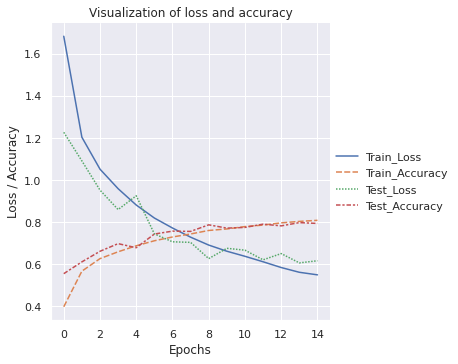

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def visualization(lists):
    """Visualizes accuracy and loss for training and test data """

    # Create lists for each visualized metric
    epochs = np.array([*range(15)])
    train_loss = np.zeros(epochs.size)
    train_accuracy = np.zeros(epochs.size)
    test_loss = np.zeros(epochs.size)
    test_accuracy = np.zeros(epochs.size) 

    # Counter used for splitting the input
    c,i = 0,0
    # Split up the metrics to the corresponding arrays
    for k in range(len(lists)):
        if k%2 == 1:
            test_loss[i] = lists[k]['loss'].numpy()
            test_accuracy[i] = lists[k]['accuracy'].numpy()
            i += 1
        else:
            train_loss[c] = lists[k]['loss'].numpy()
            train_accuracy[c] = lists[k]['accuracy'].numpy()
            c += 1
    
    # Create dictionary with all 4 metrics
    data= {'Train_Loss':train_loss, 'Train_Accuracy':train_accuracy, 'Test_Loss':test_loss, 'Test_Accuracy':test_accuracy}

    # Plot the metrics
    sns.set_theme()
    sns.relplot(data=data, kind='line').set(title='Visualization of loss and accuracy',xlabel='Epochs', ylabel='Loss / Accuracy')#, x='Epochs', y='Train_Loss',kind='line', legend='auto')

visualization(lists)
